# Modeling

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats as ss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import prince
import pprint

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,\
                            roc_curve, roc_auc_score, classification_report, confusion_matrix
from trelawney.shap_explainer import ShapExplainer
from trelawney.surrogate_explainer import SurrogateExplainer
from trelawney.lime_explainer import LimeExplainer
from xgboost import plot_importance

In [4]:
df = pd.read_csv('marriage_eng.csv', index_col=0)

In [5]:
df.head()

,Unnamed: 0.1,age,education,education_num,marital_status,occupation,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,1,50,Bachelors,13,1,White,White,Male,0,0,13,United-States,<=85k
1,2,38,HS-grad,9,0,Blue,White,Male,0,0,40,United-States,<=85k
2,3,53,<HS,8,1,Blue,Black,Male,0,0,40,United-States,<=85k
3,4,28,Bachelors,13,1,White,Black,Female,0,0,40,Latin-America,<=85k
4,5,37,Masters,14,1,White,White,Female,0,0,40,United-States,<=85k


### Confusion Matrix/Correlation Heatmap for both discrete and continuous variables

#### chi2 or cramer's v

In [6]:
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [7]:
# confusion_matrix1 = pd.crosstab(df['education'], df['occupation'])

In [8]:
# cramers_v(confusion_matrix1)

In [9]:
corrMatrix = df_dummies.corr()

NameError: name 'df_dummies' is not defined

# Preprocessing

### Split dataset into features and target variables

In [10]:
X = df.loc[:, ['age', 'education', 'occupation', 'sex', 'race', 'capital_gain', 'capital_loss',
                'hours_per_week', 'native_country', 'income']]
y = df.loc[:, 'marital_status']

In [11]:
X.head()

,age,education,occupation,sex,race,capital_gain,capital_loss,hours_per_week,native_country,income
0,50,Bachelors,White,Male,White,0,0,13,United-States,<=85k
1,38,HS-grad,Blue,Male,White,0,0,40,United-States,<=85k
2,53,<HS,Blue,Male,Black,0,0,40,United-States,<=85k
3,28,Bachelors,White,Female,Black,0,0,40,Latin-America,<=85k
4,37,Masters,White,Female,White,0,0,40,United-States,<=85k


Create a list for categorical columns

In [ ]:
cat_columns = ['education', 'occupation', 'sex', 'race', 'native_country', 'income']
cont_columns = ['age', 'capital_gain', 'capital_loss', 'hours_per_week']

Encode each categorical feature separately

In [ ]:
# label_encoders = {}
# for col in cat_columns:
#     print('Encoding {}'.format(col))
#     new_LE = LabelEncoder()
#     X[col] = new_LE.fit_transform(df[col])
#     label_encoders[col] = new_LE

In [ ]:
# cat_columns_index = [X.columns.get_loc(col) for col in cat_columns]

In [ ]:
# # One-hot encode the training data and show the resulting DataFrame with proper column names
# ohe = OneHotEncoder(categories=cat_columns, sparse=False, handle_unknown='ignore')

# X_np = ohe.fit_transform(df)
# # X_train_ohe = ohe.transform(X_train)#.toarray()

This was from Dan's GoT presentation

In [ ]:
# df_ohe = pd.concat([X[cont_columns], pd.get_dummies(X[cat_columns])], axis=1)

In [ ]:
# df_ohe.head(1)

### Get dummy variables for categorical data

In [12]:
df_dummies = pd.get_dummies(X, drop_first=False)

In [13]:
df_dummies.columns

Index(['age', 'capital_gain', 'capital_loss', 'hours_per_week',
       'education_<HS', 'education_Assoc-acdm', 'education_Assoc-voc',
       'education_Bachelors', 'education_Doctorate', 'education_HS-grad',
       'education_Masters', 'education_Prof-school', 'education_Some-college',
       'occupation_Blue', 'occupation_White', 'sex_Female', 'sex_Male',
       'race_Amer-Indian-Eskimo', 'race_Asian-Pac-Islander', 'race_Black',
       'race_Other', 'race_White', 'native_country_Canada',
       'native_country_China', 'native_country_England',
       'native_country_France', 'native_country_Germany',
       'native_country_Greece', 'native_country_Hungary',
       'native_country_India', 'native_country_Iran', 'native_country_Ireland',
       'native_country_Italy', 'native_country_Jamaica',
       'native_country_Japan', 'native_country_Latin-America',
       'native_country_Outlying-US(Guam-USVI-etc)', 'native_country_Poland',
       'native_country_Portugal', 'native_country_SE-As

In [14]:
df_dummies['education_inc_HS'] = df_dummies['education_<HS']
df_dummies['income_high'] = df_dummies['income_>85k']
df_dummies['income_low'] = df_dummies['income_<=85k']


In [15]:
# Removed < and > from feature names which seems to give XGBoost some problems
df_dummies.drop(['education_<HS', 'income_>85k', 'income_<=85k'], axis=1, inplace=True)

## PCA + MCA = MFA (Multiple Factor Analysis)

### Train Test Split (70/30)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_dummies, y, test_size=.3, random_state=42)

### Scale/Normalize data

Column Transform continuous features (not necessary for decision trees)

In [ ]:
Z_train

In [ ]:
ct = ColumnTransformer([
    ('standardized', StandardScaler(), ['age', 'capital_gain', 'capital_loss', 'hours_per_week'])
], remainder='passthrough')

Z_train = ct.fit_transform(X_train)
Z_test = ct.transform(X_test)

# Model with Multiple Classifiers

In [ ]:
# Try a collection of classifiers
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest", "XGBoost", "Neural Net", "Logistic Regression"]

classifiers = [
#     3 or 5 KNN seem ideal
    KNeighborsClassifier(3),
#     ['linear', 'poly', 'rbf', 'sigmoid'] all produce similar results
#     SVC(kernel="linear", C=0.025, random_state=42),
#     SVC(gamma=2, C=1, random_state=42),
    DecisionTreeClassifier(criterion='entropy'),
    RandomForestClassifier(criterion='gini', max_depth=5, n_estimators=10, max_features=3, random_state=42),
    XGBClassifier(n_estimators=1000, learning_rate=.02, random_state=42),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    LogisticRegression(solver='liblinear', random_state=42)
]

In [ ]:
# Untuned classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    print(f'       F1 - {name}: {f1_score(y_test, clf.predict(Z_test)):.2f}')
    print(f'Precision - {name}: {precision_score(y_test, clf.predict(Z_test)):.2f}')
    print(f'   Recall - {name}: {recall_score(y_test, clf.predict(Z_test)):.2f}')
    print(f' Accuracy - {name}: {accuracy_score(y_test, clf.predict(Z_test)):.2f}')
    print('\n')

In [17]:
model = XGBClassifier(n_estimators=1000, learning_rate=.02, random_state=42)
xgb1 = model.fit(X_train, y_train)

# Feature Explanations

In [ ]:
xgb_fea_imp = pd.DataFrame(list(xgb1.get_booster().get_fscore().items()),
columns = ['feature','importance']).sort_values('importance', ascending=False)
print('',xgb_fea_imp)

The measures are based on the number of times a variable is selected for splitting, weighted by the squared improvement to the model as a result of each split, and averaged over all trees. 

In [ ]:
ax = plot_importance(model, importance_type='gain', title='No Dummies Dropped (GAIN)')
fig = ax.figure
fig.set_size_inches(8,12)

In [ ]:
ax = plot_importance(model, importance_type='weight', title='No Dummies Dropped (WEIGHT)')
fig = ax.figure
fig.set_size_inches(8,12)

In [ ]:
ax = plot_importance(model, importance_type='total_cover', title='No Dummies Dropped (COVER)')
fig = ax.figure
fig.set_size_inches(8,12)

In [ ]:
# #Available 
# importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
# for t in importance_types:
#     pprint.pprint('Classifier: {}, Score: {}'.format(t, XGBClassifier.get_booster(model).get_score(importance_type=t)))

## ATTEMPT SHAP EXPLAINER

In [ ]:
model = RandomForestClassifier(criterion='gini', max_depth=5, n_estimators=10, max_features=3, random_state=42)

In [ ]:
model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

In [ ]:
explainer = ShapExplainer()
explainer.fit(model, X_train, y_train)

In [ ]:
feature_importance_graph = explainer.graph_feature_importance(X_test)
feature_importance_graph.update_layout(title='SHAP Feature Importance')
feature_importance_graph.show()

## ATTEMPT SURROGATE EXPLAINER

In [ ]:
explainer = SurrogateExplainer(DecisionTreeClassifier(max_depth=4))
explainer.fit(model, X_train, y_train)

In [ ]:
metrics = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]

In [ ]:
for i,m in enumerate(metrics):
    print('For {} Adequation Score = {}'.format(m, explainer.adequation_score(metric=m)));
    

## ATTEMPT LIME EXPLANATION (explainable models which approximate a model around single predictions)

In [ ]:
model

In [ ]:
y_pred = pd.DataFrame(model.predict_proba(X_test)[:,1], index=X_test.index)

In [ ]:
most_probable = y_pred.idxmax()
biggest_false_positive = (y_pred - y_test).idxmax()
biggest_false_negative = (y_pred - y_test).idxmin()

In [ ]:
explainer = LimeExplainer()
explainer.fit(model, X_train, y_train)

In [ ]:
X_test.loc[most_probable, :]

In [ ]:
lime_explanation_graph = explainer.graph_local_explanation(X_test.loc[most_probable, :])
lime_explanation_graph.update_layout(title='Lime individual prediction interpretation')
lime_explanation_graph.show();

In [ ]:
X.loc[biggest_false_positive, :]

# Hyperparameter Tuning with GridSearchCV

K Nearest Neighbor

In [ ]:
KNN_clf = KNeighborsClassifier()

In [ ]:
param_grid = {
    'n_neighbors': range(1,5),
    'weights': ['uniform', 'distance'],
    'metric': ['manhattan', 'euclidean', 'minkowski'],
    'n_jobs': [-1]
}

gs_tree = GridSearchCV(KNN_clf, param_grid, cv=3)
gs_tree.fit(X_train, y_train)

gs_tree.best_params_

Support Vector Classifier

In [ ]:
SVC_clf = SVC()

In [ ]:
param_grid = {
    'C': np.linspace(.1,1,10),
    'degree': [2,3,4,5],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

gs_tree = GridSearchCV(SVC_clf, param_grid, cv=3)
gs_tree.fit(X_train, y_train)

gs_tree.best_params_

Decision Tree Classifier

In [ ]:
dtree_clf = DecisionTreeClassifier()

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(2,20)
}

gs_tree = GridSearchCV(dtree_clf, param_grid, cv=3)
gs_tree.fit(X_train, y_train)

gs_tree.best_params_

Random Forest

In [ ]:
rforest_clf = RandomForestClassifier()

In [ ]:
param_grid = {
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_depth': range(2,20,2),
    'n_estimators': range(10,100,10)
}

gs_tree = GridSearchCV(rforest_clf, param_grid, cv=3)
gs_tree.fit(X_train, y_train)

gs_tree.best_params_

XG Boost

In [ ]:
XGB_clf = XGBClassifier()

In [ ]:
list(XGB_clf.get_params().keys())

In [ ]:
param_grid = {
   'learning_rate': np.linspace(.3,.7,5),
    'n_estimators': range(100,1000,100),
    'gamma': [.5,1,1.5,2],
    'max_depth': [2,3,4,5,6]
    
}

gs_tree = GridSearchCV(XGB_clf, param_grid, cv=3, verbose=True, n_jobs=-1)
gs_tree.fit(X_train, y_train)

gs_tree.best_params_

Neural Net

In [ ]:
MLP_clf = MLPClassifier(max_iter=100)

In [ ]:
list(MLP_clf.get_params().keys())

In [ ]:
param_grid = {
    'alpha': 10.0**-np.arange(1,10), 
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['logistic', 'relu', 'tanh'],
    'solver': ['sgd', 'adam'],
}

gs_tree = GridSearchCV(MLP_clf, param_grid, cv=3, verbose=True, n_jobs=-1)
gs_tree.fit(X_train, y_train)

gs_tree.best_params_

# Model Performance

Confusion Matrix

In [19]:
y_pred_class = xgb1.predict(X_test)

In [20]:
cm = confusion_matrix(y_test, y_pred_class)

In [23]:
classes = ['Divorced', 'Married']

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix, without normalization
[[1004  682]
 [ 244 3931]]


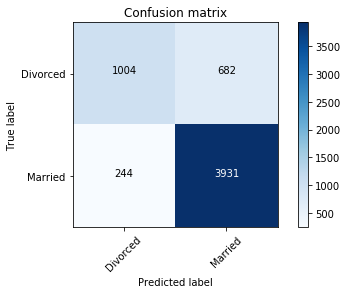

In [25]:
import itertools
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

Classification Report

In [28]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.80      0.60      0.68      1686
           1       0.85      0.94      0.89      4175

    accuracy                           0.84      5861
   macro avg       0.83      0.77      0.79      5861
weighted avg       0.84      0.84      0.83      5861



## ROC/AUC

In [ ]:
# Dummy prediction
dummy_probs = [0 for _ in range(len(y_test))]

In [ ]:
# predict probabilities
xgb_probs = xgb1.predict_proba(X_test)

In [ ]:
# keep probs for positive outcome only
xgb_probs = xgb_probs[:,1]

In [ ]:
# calc scores
dummy_auc = roc_auc_score(y_test, ns_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)

In [ ]:
# summarize scores
print('No Skill: ROC AUC=%.3f' % (dummy_auc))
print('XGBoost: ROC AUC=%.3f' % (xgb_auc))

In [ ]:
# calc ROC curves
dummy_fpr, dummy_tpr, _ = roc_curve(y_test, dummy_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)

In [ ]:
# plot the roc curve for XGBoost model
plt.plot(dummy_fpr, dummy_tpr, linestyle='--', label='Dummy Classifier')
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()